# 1. Import required modules

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

# 2. Define common parameters for image loading here:

In [158]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 4

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict =  {"dna":1,"Mdc1":2,"Fibirill":3,"Pol2S5":4}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"

nucleoli_key="Fibirill"

dna_key = 'dna'  # temporary fix since DNA is not good
#h2ax_key="H2ax"
pol2_key = 'Pol2S5'

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:True,4:True}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done







############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################


############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
#data_main_folder = r"D:\Analyzed_CellBio\Stam\Dam_analysis_batchB\211007IF_210922exp_DamMN"
#data_save_folder = data_main_folder + os.sep + well_name + r"_doxPlusAID\*"

data_save_folder = r"D:\Analyzed_CellBio\Stam\cov1_Mdc1-488 Fibrill-568 PolS5-647\*"


data_main_folder = r"D:\Analyzed_CellBio\Stam\cov1_Mdc1-488 Fibrill-568 PolS5-647"


analysis_prefix = 'Fib_Pol2'
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_folder = data_save_folder
data_files = [file for file in glob.glob(data_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\cov1_RPE1 Mdc1-488 Fibrill-568 PolS5-647_.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\cov1_RPE1 Mdc1-488 Fibrill-568 PolS5-647_001.nd2',
 'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647\\cov1_RPE1 Mdc1-488 Fibrill-568 PolS5-647_002.nd2']

In [159]:
data_main_folder

'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647'

# 3. Generate cell annotation dict from annotation file

In [160]:
# not used here

In [161]:
#debug_cell_info_dict ={'well3_m6T-488 H2AX-568 RNApol647_024.nd2': {'1': [[1180, 990]]}}

#cell_info_dict = debug_cell_info_dict

In [162]:
#del cell_info_dict['well3_m6T-488 H2AX-568 RNApol647_009.nd2']['6']

# 4. Adjust other parameters for image analysis

In [163]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
#_analyze_all_nd = False
_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    fov_to_exclude_dict = {1:[ [7-1, 19-1]]} # exclude fov 6 and 18 in exp1 (index start from 1)
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
small_53BP_size = 100


# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 600


# minimal toal nucleoli areas
nucleoli_size = 100


# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3 # for fibrillin actually
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be okay since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
#if not use_dna_nuclei:
    #dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [500,1500] # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = False

# 5. Analyze each fovs and cells

In [164]:
# analyze cells of interest below

In [165]:
#h2ax_std_ratio

In [166]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()

####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]
    
    #------------------------------------------------------#
    # temp fix for the naming error in the anntotation excel
    #data_name_p1 = data_name.split('PolS5-647')[0]
    #data_name_p2 = data_name.split('PolS5-647')[-1]
    #data_name = data_name_p1 + 'RNApol647' + data_name_p2
    
    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
        
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused (ind start from 0)
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
     
    
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in fov_of_interest[:]:                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei segmenation to roughly look for cell of interest
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    # use pol2 for whole rough image
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[pol2_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                
                
                if use_dna_nuclei: # use dapi staining 
                    th_value =  threshold_li (image_cell_3d)
                    nuclei_mask_3d = image_cell_3d>th_value
   
                #------------------------------------------------------#
                # current method for alternative dna segmentation 
                else: # use e.g., Pol2 staining 
                    th_value =  threshold_otsu  (image_cell_3d)
                    nuclei_mask_3d =  (image_cell_3d) >th_value
                    
                eroded_nuclei_mask_3d = erosion(nuclei_mask_3d, ball(1))
                #eroded_nuclei_mask = dilation(eroded_nuclei_mask, disk(erosion_factor_dna))
                
                eroded_nuclei_mask_3d = ndi.binary_fill_holes(eroded_nuclei_mask_3d)
                eroded_nuclei_mask_3d = remove_small_objects(eroded_nuclei_mask_3d, nuclei_filter*num_of_planes/3,
                                                          connectivity=1)
                
                # rough 3d nuclei segmentation to get all valid nuclei of interest
                labeled_nuclei_3d, num_of_nuclei_3d = ndi.label(eroded_nuclei_mask_3d)
                #print(num_of_nuclei)
                # store the coord to prepare for refined analysis
                cell_coord_list  = []
                for i in range(num_of_nuclei_3d):
                    cand_nucleus = labeled_nuclei_3d == i+1
                    cand_nucleus[cand_nucleus>0]=1
                    cand_nucleus = np.array(cand_nucleus)
                    # append the coord for the objects of interest
                    region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                    # centroid coord as zYX
                    if region.centroid[2] >= search_xylim[0] and region.centroid[2] <= search_xylim[1]:
                        if region.centroid[1] > search_xylim[0] and region.centroid[1] < search_xylim[1]:
                            cell_coord_list.append([int(region.centroid[2]),int(region.centroid[1])])
                if _verbose:
                    print (f'-- Processing {len(cell_coord_list)} cells from the image {_fov_id+1}.')

###########################################################################################                            
# Loop through the cell coord list to analyze cells of interest
                        
            for _cell_id, cell_center in enumerate(cell_coord_list[:]):        
                # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                #image_fl = []
                image_std = []
                image_3d_for_label = []
                
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                    # do cropping if necessary; remember to inver XY
                    if crop_image: # current crop size as rough cell size
                        crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                        crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                        crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                        crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                        image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]
                    # use image signal STD distribution to find the best focal plane for the plane of interest
                    _fl=image_array_fl.flatten()
                    # if refine by using a slightly smaller crop
                    if narrow_adjust:
                        _size = image_array_fl.shape
                        _fl=image_array_fl[int(_size[0]*narrow_ratio/2):-int(_size[0]*narrow_ratio/2),
                                           int(_size[1]*narrow_ratio/2):-int(_size[1]*narrow_ratio/2)].flatten() 
                    #image_fl.append(_fl)
                    image_std.append(np.std(_fl))
                    
                    #also pend the image for later potential usage (eg. re-adjust focal plane)
                    image_3d_for_label.append(image_array_fl)
                # find the initial best focal plane            
                best_plane_index = np.argmax(np.array(image_std))
                if _verbose:
                    print(f"-- Analyzing the cell {_cell_id+1} for the plane {best_plane_index+1} in fov {_fov_id+1}.")
                    
                # load the best focal plane (for each cropped area)
                ch_img_dict={}
                for _index, _ch in enumerate(range(num_of_ch)):
                    sel_img = np.array(images.get_frame_2D (v=_fov_id, c= _ch, z=best_plane_index))
                    if crop_image: # current crop size as rough cell size
                        sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                  
                    # Update/Generate the img_dict
                    ch_img_dict[str(_index+1)] = sel_img

                # RE-Generate the refined 2D nuclei mask for each cell
                if use_dna_nuclei:  # use dapi
                    th_value =  threshold_li (ch_img_dict[str(ch_dict[dna_key])])
                    nuclei_mask = ch_img_dict[str(ch_dict[dna_key])]>th_value
                else: # use Pol2 currently
                    th_value =  threshold_otsu (ch_img_dict[str(ch_dict[dna_key])])
                    nuclei_mask = ch_img_dict[str(ch_dict[dna_key])]>th_value
                
                eroded_nuclei_mask = erosion(nuclei_mask, disk(erosion_factor_dna))
                eroded_nuclei_mask = dilation(eroded_nuclei_mask, disk(erosion_factor_dna))

                
                eroded_nuclei_mask = ndi.binary_fill_holes(eroded_nuclei_mask)
                eroded_nuclei_mask = remove_small_objects(eroded_nuclei_mask, nuclei_filter,connectivity=1)
                
                if not use_dna_nuclei: # for Pol2 currently
                    eroded_nuclei_mask = skimage.filters.median (eroded_nuclei_mask, disk(10))
      
                # generate the non-cell background
                noncell_background = erosion(eroded_nuclei_mask==0,disk(10))
        
                # if do further erosion and dilation to remove micronuclei #or small blebs
                #eroded_nuclei_mask = erosion(eroded_nuclei_mask, disk(erosion_factor_dna))
                #eroded_nuclei_mask = dilation(eroded_nuclei_mask, disk(erosion_factor_dna))
                # Nuclei segmentation to get all valid nuclei of interest
                labeled_nuclei, num_of_nuclei = ndi.label(eroded_nuclei_mask)
                
##########################################################################################################                
                # Find the nuclei of interest to the list for downstream analysis (should typically have only one)
                kept_nuclei_info = []
                for i in range(num_of_nuclei):
                    cand_nucleus = labeled_nuclei == i+1
                    cand_nucleus[cand_nucleus>0]=1
                    cand_nucleus = np.array(cand_nucleus)
                    
                    # find the labeled nuclei close enough to the center of the cropped image (with 50 pixel)
                    region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                    # centroid coord as YX
                    if crop_image: # use crop center
                        _dist_diff = np.linalg.norm(np.array([region.centroid[1], region.centroid[0]])
                                                    - np.array([cell_size/2,cell_size/2]))
                        if _dist_diff <= coord_dist:
                            kept_nuclei_info.append([cand_nucleus,_dist_diff])
                            
                    else: # use cell center coord (in terms of the original image)
                        _dist_diff = np.linalg.norm(np.array([region.centroid[1], region.centroid[0]]) - 
                                                    np.array(cell_center))
                        if _dist_diff <= coord_dist:
                            kept_nuclei_info.append([cand_nucleus,_dist_diff])
                            
                # Pick the closest segmented objects for analysis
                if len(kept_nuclei_info) >0:
                    
                    _dist_diff_list =[]
                    for _object in kept_nuclei_info:
                        _dist_diff_list.append(_object[1])
                    _dist_diff_list= np.array(_dist_diff_list)
                    _closest_object_index = np.argmin(_dist_diff_list)
                    
#########################################################################################################
            # Proceed to cell specific analysis:
                    # load mask for the nuclei to measure
                    nuclei_to_measure = kept_nuclei_info[_closest_object_index][0]
                    # set measurement list
                    measurement_list = []      
                    # save the xy for the cell picked for the specified cell center
                    sel_nuclei_xy = cell_center

#########################################################################################################
            # Re-adjust the focal plane if necessary:
                    # if re-adjust focal plane specifically for the target cell only
                    if adjust_z_for_cell:
                        image_std_filtered = []
                        for _lyr in image_3d_for_label:
                            image_3d_for_label_filtered = (_lyr*nuclei_to_measure).flatten()
                            image_std_filtered.append(np.std(image_3d_for_label_filtered))
                        # find the refined best focal plane            
                        best_plane_index = np.argmax(np.array(image_std_filtered))
                        # re-load images using the refined focal plane
                        if _verbose:
                            print (f'-- Re-adjusting the plane as {best_plane_index+1}.')
                        ch_img_dict={}
                        for _index, _ch in enumerate(range(num_of_ch)):
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= _ch, z=best_plane_index))
                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                  
                            # Update/Generate the img_dict
                            ch_img_dict[str(_index+1)] = sel_img
                            
#########################################################################################################
            # Start the final mask segmenation for area of interest from here for each nuclei of interest:
                    # Set minimal MDC1 foci size if undefined
                    if small_53BP_size == 0:
                        small_53BP_size = 30
    ###################################################################
                      #save raw images if necessary
                    if crop_image:
                        if save_crop_raw_image: 
                            raw_save_path = data_main_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                            f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                            if not os.path.exists(raw_save_path):
                                os.makedirs(raw_save_path)
                            if _verbose:
                                print(f'-- Saving cropped raw images for cell {_cell_id+1} in this fov.')
                                
                            #raw_savename_list = []
                            #raw_image_list = []
                            
                            for _ch_key in ch_img_dict.keys():
                                raw_savename = f'cell_{_cell_id+1}_ch_{int(_ch_key)}_raw.tif'
                                #raw_savename_list.append(raw_savename)
                                if os.path.exists(raw_save_path+os.sep+raw_savename):
                                    os.remove(raw_save_path+os.sep+raw_savename)
                                io.imsave(raw_save_path+os.sep+raw_savename,
                                          (ch_img_dict[_ch_key]), check_contrast=False)                   

    ########################################################################    
                    # Get cellular mdc mask 
                    mdc_intensity = (ch_img_dict[str(ch_dict[mdc1_key])])*nuclei_to_measure
                    mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                    mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                    mdc_mask = np.logical_and(ch_img_dict[str(ch_dict[mdc1_key])]>mdc_positive_th, nuclei_to_measure)
                    
                    # Set minimal MDC1 foci size
                    #if small_53BP_size == 0:
                        #small_53BP_size = 30
                    mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                    
                    # Proceed if the nuclei has a valid MDC-positive foci
                    #if np.sum(mdc_chr_mask)>=small_53BP_size:
                    #proceed for all 
                    
  ######################################################################################################
                 # for fibrillin positive and negative area for each cell#
                        # Generate masks for fibrilin positive region
                        # use part of the existing h2ax procedures for fibrilian 
                    h2ax_key = nucleoli_key
                    h2ax_intensity = ch_img_dict[str(ch_dict[h2ax_key])]*nuclei_to_measure
                    h2ax_intensity_filtered = h2ax_intensity[h2ax_intensity!=0]
                    h2ax_positive_th = np.mean(h2ax_intensity_filtered) + 3* np.std(h2ax_intensity_filtered)
                       
                    h2ax_foci_mask = np.logical_and((ch_img_dict[str(ch_dict[h2ax_key])] > h2ax_positive_th),
                                                        nuclei_to_measure)
                        # remove small fibril nosie signal from the mask
                    h2ax_foci_mask = remove_small_objects(h2ax_foci_mask, small_nucleoli_dirt, connectivity=1)
                        
    
                    # mask for fibri negative area within the incorporated chr; 
                
                    h2ax_negative_inc_chr_mask = np.logical_xor(nuclei_to_measure, h2ax_foci_mask)
                
                
 ##############################################################################               
                
                
                    # only for good staining of fibril
                    if np.sum(h2ax_foci_mask) > nucleoli_size: # try to find cells with decent nucleoli area
                        if _verbose:
                            print(f'-- Measuring cell {_cell_id+1} in fov {_fov_id+1}.')
                            
                            
                        # get a radmon subset area for the negative area as well
                        _seed_size = np.sum(h2ax_foci_mask)
                        _random_index= np.random.choice(np.sum(h2ax_negative_inc_chr_mask), 1)
                        _random_yx = [np.where(h2ax_negative_inc_chr_mask==1)[0][_random_index],
                              np.where(h2ax_negative_inc_chr_mask==1)[1][_random_index]]
                        
                        _seed_mask = np.zeros(h2ax_negative_inc_chr_mask.shape)
                        _seed_mask [_random_yx[0][0],_random_yx[1][0]] = 1
                
                        _expand_seed = True
                        while _expand_seed:
                            _seed_mask = dilation(_seed_mask, disk(3))
                            #print (f'-- Generate seed mask for cell {_cell_id}')
                            _subset_h2ax_negative_inc_chr_mask = _seed_mask * (h2ax_negative_inc_chr_mask == 1) * (h2ax_foci_mask == 0)
                            if np.sum(_subset_h2ax_negative_inc_chr_mask) >= _seed_size: 
                                _expand_seed = False 
                                #print (f'-- Found control mask for cell {_cell_id}')
                        _erode_seed = True
                        while _erode_seed:
                            if np.sum(_subset_h2ax_negative_inc_chr_mask) >= _seed_size + 100:
                                _subset_h2ax_negative_inc_chr_mask = erosion(_subset_h2ax_negative_inc_chr_mask, disk(1))
                            else:
                                _erode_seed = False
                        
                        h2ax_negative_inc_chr_mask =_subset_h2ax_negative_inc_chr_mask
                            
                            
                
#####################################################################################################    
                  # for whole cell without any low-Pol2 area exclusion
                        # Generate mask for the rest chr in nuclei by removing the mdc-labeled and nucleolus regions
                        all_ctrl_chr_mask = nuclei_to_measure * (mdc_chr_mask == 0) # but without nucleoli exclusion
                        # define same variable only for later function usage
                        nucleo_ex_chr_mask =all_ctrl_chr_mask
###################################################################################################################  
                  # calculate the overlapping between fib-positive and mdc-positive
                        overlap_fib_mdc_mask = h2ax_foci_mask * mdc_chr_mask
                    
 ########################################################################################################                   
                        # Generate a subset of the rest chr as randomized contrl
                        
                        # for a size of ~100 -300
                        if np.sum(mdc_chr_mask) <small_53BP_size:
                            _seed_size = np.random.randint(100,300)
                        else:
                            _seed_size = np.sum(mdc_chr_mask)
                            
                        _random_index= np.random.choice(np.sum(nucleo_ex_chr_mask), 1)
                        _random_yx = [np.where(nucleo_ex_chr_mask==1)[0][_random_index],
                              np.where(nucleo_ex_chr_mask==1)[1][_random_index]]
                        
                        _seed_mask = np.zeros(nucleo_ex_chr_mask.shape)
                        _seed_mask [_random_yx[0][0],_random_yx[1][0]] = 1
                
                        _expand_seed = True
                        while _expand_seed:
                            _seed_mask = dilation(_seed_mask, disk(3))
                            #print (f'-- Generate seed mask for cell {_cell_id}')
                            _subset_ctrl_chr_mask = _seed_mask * (nucleo_ex_chr_mask == 1) * (mdc_chr_mask == 0)
                            if np.sum(_subset_ctrl_chr_mask) >= _seed_size: 
                                _expand_seed = False 
                                #print (f'-- Found control mask for cell {_cell_id}')
                        _erode_seed = True
                        while _erode_seed:
                            if np.sum(_subset_ctrl_chr_mask) >= _seed_size + 100:
                                _subset_ctrl_chr_mask = erosion(_subset_ctrl_chr_mask, disk(1))
                            else:
                                _erode_seed = False
                        
#########################################################################################################
                        # measurement list for each channel for each cell
                        measurement_for_each_cell = []
                        
                        # Add exp name and fov_id and cell_id  [4 here]
                        measurement_for_each_cell.append (data_save_folder.split('\\')[-2])  # exp name
                        measurement_for_each_cell.append (f'{data_name}_Pos{_fov_id+1}')  # FOV name
                        measurement_for_each_cell.append (int(_cell_id+1))   # cell id
                        measurement_for_each_cell.append ([sel_nuclei_xy, best_plane_index+1])  # cell xy,z
                        # Measure and add pixel area for MDC-labeled chromosome, 
                        # [6 here]
                        measurement_for_each_cell.append (np.sum(mdc_chr_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_foci_mask))
                        measurement_for_each_cell.append (np.sum(h2ax_negative_inc_chr_mask))
                        measurement_for_each_cell.append (np.sum(all_ctrl_chr_mask))
                        measurement_for_each_cell.append (np.sum(overlap_fib_mdc_mask))
                        measurement_for_each_cell.append (np.sum(_subset_ctrl_chr_mask))
                        
                        # Measure background-substracted intensity for each channel
                        # measure intensity for each ch in the order of dna, mdc1, h2ax, pol2
                        for ch in [ch for ch in ch_dict.values()]:
                            ch_to_measure = ch_img_dict[str(ch)]
                        
                            # Measure ave intensity
                            # mdc1
                            mdc_chr_ave_intensity = np.mean((ch_to_measure * mdc_chr_mask)[mdc_chr_mask!=0])
                            # all ctrl chromosome
                            ctrl_chr_ave_intensity = np.mean((ch_to_measure * all_ctrl_chr_mask)[all_ctrl_chr_mask!=0])

                            # non-cell background
                            noncell_background_ave_intensity = np.mean((ch_to_measure*noncell_background)
                                                                       [noncell_background!=0])
                                                          
                            # subset ctrl chromosome                             
                            subset_ctrl_chr_ave_intensity = np.mean((ch_to_measure * _subset_ctrl_chr_mask)
                                                                   [_subset_ctrl_chr_mask!=0])

                            # Background subtraction
                            mdc_chr_ave_intensity = mdc_chr_ave_intensity - noncell_background_ave_intensity
                            ctrl_chr_ave_intensity = ctrl_chr_ave_intensity - noncell_background_ave_intensity
                                                          
                            subset_ctrl_chr_ave_intensity = subset_ctrl_chr_ave_intensity - noncell_background_ave_intensity
                                                          
                    
                            # Add measurements  [3* 4 ch = 12 here]
                            measurement_for_each_cell.append(mdc_chr_ave_intensity)
                            measurement_for_each_cell.append(ctrl_chr_ave_intensity)         
                            measurement_for_each_cell.append(subset_ctrl_chr_ave_intensity)
                                                          
                            
                            # fibrillin-positive and negative [2* 4 ch = 8 here]
                            # measure pol/h2ax for subregions of incorporated chr (damaged vs non-damaged)
                            #if ch == ch_dict[h2ax_key] or ch == ch_dict[pol2_key]:
                            analyze_ch_for_2nd_marker = analyze_ch_for_2nd_marker_dict[ch]
                            if analyze_ch_for_2nd_marker:
                                # no erosion for fibrilin
                                h2ax_foci_mask_eroded = h2ax_foci_mask
                                h2ax_negative_inc_chr_mask_eroded = h2ax_negative_inc_chr_mask

                                if _verbose: # indentation only
                                    h2ax_pos_chr_ave_intensity = np.mean((ch_to_measure * h2ax_foci_mask_eroded)
                                                                         [h2ax_foci_mask_eroded!=0])
                                    
                                    h2ax_pos_chr_ave_intensity = (h2ax_pos_chr_ave_intensity - 
                                                                  noncell_background_ave_intensity)
                                      
                                else: # skip empty mask
                                    h2ax_pos_chr_ave_intensity = np.nan
                            
                                if _verbose: # indentation only
                                    
                                    h2ax_neg_chr_ave_intensity = np.mean((ch_to_measure * h2ax_negative_inc_chr_mask_eroded)
                                                                         [h2ax_negative_inc_chr_mask_eroded!=0])
                                    h2ax_neg_chr_ave_intensity = h2ax_neg_chr_ave_intensity - noncell_background_ave_intensity
                                else:  # skip empty mask
                                    h2ax_neg_chr_ave_intensity = np.nan
                                # Add measurements
                                measurement_for_each_cell.append(h2ax_pos_chr_ave_intensity)
                                measurement_for_each_cell.append(h2ax_neg_chr_ave_intensity)
                                      
################################################################################################################
                       # Add measurement columns for each cell to the measurements dataframe for all fovs   
                        measurement_for_each_cell_df = pd.DataFrame()
                           
                        ch_save_list = ['dna', 'mdc1', 'fibrill', 'Pol2S5']

                        ch1 = ch_save_list[0]
                        ch2 = ch_save_list[1]
                        ch3 = ch_save_list[2]
                        ch4 = ch_save_list[3]                

                        # total of 5 * 4 (for subset control) measurements
                        col_names = ['exp_name','position_id','cell_id', 'cell_xyz_coord',  #4 for basic info
                   
                   'area_incorporated_chr','area_fibril_positive','area_fibril_negative',
                   'area_control_chr','area_mdc_fib_overlap', 'area_subset_control_ctrl', #6 for masks size
                   
             f'ave_intensity_incorporated_chr_{ch1}',f'ave_intensity_control_chr_{ch1}',
                  
                                     f'ave_intensity_subset_control_chr_{ch1}',
                   f'ave_intensity_fibril_pos_{ch1}',f'ave_intensity_fibril_neg_{ch1}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch2}',f'ave_intensity_control_chr_{ch2}',
                 
                                     f'ave_intensity_subset_control_chr_{ch2}',
                   f'ave_intensity_fibril_pos_{ch2}',f'ave_intensity_fibril_neg_{ch2}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch3}',f'ave_intensity_control_chr_{ch3}',
                  
                                     f'ave_intensity_subset_control_chr_{ch3}',
                   f'ave_intensity_fibril_pos_{ch3}',f'ave_intensity_fibril_neg_{ch3}',
                   
                   
                   f'ave_intensity_incorporated_chr_{ch4}',f'ave_intensity_control_chr_{ch4}',
                 
                                     f'ave_intensity_subset_control_chr_{ch4}',
                  f'ave_intensity_fibril_pos_{ch4}',f'ave_intensity_fibril_neg_{ch4}',
                   ]
                        
                        
                        for _col_name, _measurement in zip(col_names, measurement_for_each_cell):
                            measurement_for_each_cell_df[_col_name] = [_measurement]
                        
                        
                        measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])
                        
################################################################################################################
                       # Save mask segmentations for each cell 
    
                        # segmentation mask for each cell
                        # Save mask images in the source directory
                        mask_save_path = data_main_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                        if not os.path.exists(mask_save_path):
                            os.makedirs(mask_save_path)
                        if _verbose:
                            print(f'-- Saving masks for cell {_cell_id+1} in this fov.')
                        mdc_chr_mask_savename = f'cell_{_cell_id+1}_incoporated_chr.tif'
                        h2ax_foci_mask_savename = f'cell_{_cell_id+1}_fibrillin_area.tif'
                        _subset_h2ax_negative_inc_chr_mask_savename =  f'cell_{_cell_id+1}_subset_fib_negative_area.tif'
                        ctrl_chr_mask_savename = f'cell_{_cell_id+1}_all_control_chr.tif'
                        subset_ctrl_chr_mask_savename = f'cell_{_cell_id+1}_subset_control_chr.tif'
                                                          
                        
                        mask_savename_list = [mdc_chr_mask_savename,h2ax_foci_mask_savename, 
                                              _subset_h2ax_negative_inc_chr_mask_savename,
                                              ctrl_chr_mask_savename, subset_ctrl_chr_mask_savename]
                        mask_file_list = [mdc_chr_mask,h2ax_foci_mask,
                                          _subset_h2ax_negative_inc_chr_mask,
                                          all_ctrl_chr_mask, _subset_ctrl_chr_mask] 
                        
                        for _name, _file in zip(mask_savename_list,mask_file_list):
                            # remove old ones if exist
                            if os.path.exists(mask_save_path+os.sep+_name):
                                os.remove(mask_save_path+os.sep+_name)
                            io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)
                        
                    # MEASURE and ANALYZE done for each CELL above                       
#####################################################################################################################
                   # Export results for each experiment
    
_save_results = True

if _save_results:


    if _verbose:
        print(f'-- Saving results for {len(measurement_for_all_fov_df)} cells for this dataset.')
                    
    # Replace the protein/dna name below as how they are ordered for the channel (ch405, ch488, ch560, ch647)
    # For example, ch_save_list = ["dna","rpa2","mdc1","pol2S5"] if rpa2 in ch488
    #ch_save_list = ["dna","m6T","H2AX","Pol2Se"]
    
    
    analysis_savename = f'{analysis_prefix}_measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_main_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
    
    if _verbose:
        print(f"++++++++++++++++++++++++++++++++++++++++++++++++++")                       
                        
         
         

-- Generate 3D nuclei segmentation to find cells.
-- Processing 13 cells from the image 1.
-- Analyzing the cell 1 for the plane 7 in fov 1.
-- Analyzing the cell 2 for the plane 7 in fov 1.
-- Measuring cell 2 in fov 1.
-- Saving masks for cell 2 in this fov.


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the cell 3 for the plane 8 in fov 1.
-- Analyzing the cell 4 for the plane 7 in fov 1.
-- Measuring cell 4 in fov 1.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 7 in fov 1.
-- Measuring cell 5 in fov 1.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 7 in fov 1.
-- Analyzing the cell 7 for the plane 7 in fov 1.
-- Measuring cell 7 in fov 1.
-- Saving masks for cell 7 in this fov.
-- Analyzing the cell 8 for the plane 8 in fov 1.
-- Analyzing the cell 9 for the plane 7 in fov 1.
-- Measuring cell 9 in fov 1.
-- Saving masks for cell 9 in this fov.
-- Analyzing the cell 10 for the plane 7 in fov 1.
-- Measuring cell 10 in fov 1.
-- Saving masks for cell 10 in this fov.
-- Analyzing the cell 11 for the plane 7 in fov 1.
-- Measuring cell 11 in fov 1.
-- Saving masks for cell 11 in this fov.
-- Analyzing the cell 12 for the plane 7 in fov 1.
-- Analyzing the cell 13 for the plane 7 in fov 1.
-- Measuring cell 13 i

-- Measuring cell 1 in fov 9.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 9.
-- Measuring cell 2 in fov 9.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 6 in fov 9.
-- Measuring cell 3 in fov 9.
-- Saving masks for cell 3 in this fov.
-- Analyzing the cell 4 for the plane 6 in fov 9.
-- Measuring cell 4 in fov 9.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 6 in fov 9.
-- Measuring cell 5 in fov 9.
-- Saving masks for cell 5 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 12 cells from the image 10.
-- Analyzing the cell 1 for the plane 5 in fov 10.
-- Measuring cell 1 in fov 10.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 5 in fov 10.
-- Measuring cell 2 in fov 10.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 5 in fov 10.
-- Measuring cell 3 in fov 10.
-- Saving masks for cell 3 in th

-- Analyzing the cell 4 for the plane 6 in fov 16.
-- Measuring cell 4 in fov 16.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 6 in fov 16.
-- Measuring cell 5 in fov 16.
-- Saving masks for cell 5 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 5 cells from the image 17.
-- Analyzing the cell 1 for the plane 7 in fov 17.
-- Measuring cell 1 in fov 17.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 17.
-- Measuring cell 2 in fov 17.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 7 in fov 17.
-- Analyzing the cell 4 for the plane 7 in fov 17.
-- Measuring cell 4 in fov 17.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 10 in fov 17.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 8 cells from the image 18.
-- Analyzing the cell 1 for the plane 7 in fov 18.
-- Measuring cell 1 in fov 18.
-- Saving masks for cel

-- Measuring cell 4 in fov 24.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 8 in fov 24.
-- Measuring cell 5 in fov 24.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 8 in fov 24.
-- Measuring cell 6 in fov 24.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 8 in fov 24.
-- Measuring cell 7 in fov 24.
-- Saving masks for cell 7 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 13 cells from the image 25.
-- Analyzing the cell 1 for the plane 6 in fov 25.
-- Measuring cell 1 in fov 25.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 25.
-- Measuring cell 2 in fov 25.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 6 in fov 25.
-- Measuring cell 3 in fov 25.
-- Saving masks for cell 3 in this fov.
-- Analyzing the cell 4 for the plane 6 in fov 25.
-- Measuring cell 4 in fov 25.
-- Saving masks for cel

-- Analyzing the cell 9 for the plane 6 in fov 1.
-- Measuring cell 9 in fov 1.
-- Saving masks for cell 9 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 10 cells from the image 2.
-- Analyzing the cell 1 for the plane 6 in fov 2.
-- Measuring cell 1 in fov 2.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 2.
-- Measuring cell 2 in fov 2.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 6 in fov 2.
-- Measuring cell 3 in fov 2.
-- Saving masks for cell 3 in this fov.
-- Analyzing the cell 4 for the plane 5 in fov 2.
-- Measuring cell 4 in fov 2.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 6 in fov 2.
-- Measuring cell 5 in fov 2.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 7 in fov 2.
-- Measuring cell 6 in fov 2.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 6 in fov 2.
-- Measuring cell 7

-- Analyzing the cell 5 for the plane 6 in fov 10.
-- Analyzing the cell 6 for the plane 6 in fov 10.
-- Measuring cell 6 in fov 10.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 6 in fov 10.
-- Measuring cell 7 in fov 10.
-- Saving masks for cell 7 in this fov.
-- Analyzing the cell 8 for the plane 5 in fov 10.
-- Measuring cell 8 in fov 10.
-- Saving masks for cell 8 in this fov.
-- Analyzing the cell 9 for the plane 6 in fov 10.
-- Measuring cell 9 in fov 10.
-- Saving masks for cell 9 in this fov.
-- Analyzing the cell 10 for the plane 6 in fov 10.
-- Measuring cell 10 in fov 10.
-- Saving masks for cell 10 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 14 cells from the image 11.
-- Analyzing the cell 1 for the plane 5 in fov 11.
-- Measuring cell 1 in fov 11.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 11.
-- Measuring cell 2 in fov 11.
-- Saving masks for cell 2 in this fov.


-- Processing 11 cells from the image 17.
-- Analyzing the cell 1 for the plane 5 in fov 17.
-- Measuring cell 1 in fov 17.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 6 in fov 17.
-- Measuring cell 2 in fov 17.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 6 in fov 17.
-- Measuring cell 3 in fov 17.
-- Saving masks for cell 3 in this fov.
-- Analyzing the cell 4 for the plane 6 in fov 17.
-- Measuring cell 4 in fov 17.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 6 in fov 17.
-- Measuring cell 5 in fov 17.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 6 in fov 17.
-- Measuring cell 6 in fov 17.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 6 in fov 17.
-- Measuring cell 7 in fov 17.
-- Saving masks for cell 7 in this fov.
-- Analyzing the cell 8 for the plane 5 in fov 17.
-- Measuring cell 8 in fov 17.
-- Saving masks for ce

-- Measuring cell 12 in fov 2.
-- Saving masks for cell 12 in this fov.
-- Analyzing the cell 13 for the plane 6 in fov 2.
-- Measuring cell 13 in fov 2.
-- Saving masks for cell 13 in this fov.
-- Analyzing the cell 14 for the plane 7 in fov 2.
-- Measuring cell 14 in fov 2.
-- Saving masks for cell 14 in this fov.
-- Analyzing the cell 15 for the plane 6 in fov 2.
-- Measuring cell 15 in fov 2.
-- Saving masks for cell 15 in this fov.
-- Analyzing the cell 16 for the plane 6 in fov 2.
-- Measuring cell 16 in fov 2.
-- Saving masks for cell 16 in this fov.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 17 cells from the image 3.
-- Analyzing the cell 1 for the plane 7 in fov 3.
-- Measuring cell 1 in fov 3.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the plane 7 in fov 3.
-- Measuring cell 2 in fov 3.
-- Saving masks for cell 2 in this fov.
-- Analyzing the cell 3 for the plane 6 in fov 3.
-- Measuring cell 3 in fov 3.
-- Saving masks for cell 

-- Measuring cell 5 in fov 8.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 7 in fov 8.
-- Measuring cell 6 in fov 8.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 7 in fov 8.
-- Measuring cell 7 in fov 8.
-- Saving masks for cell 7 in this fov.
-- Analyzing the cell 8 for the plane 6 in fov 8.
-- Measuring cell 8 in fov 8.
-- Saving masks for cell 8 in this fov.
-- Analyzing the cell 9 for the plane 6 in fov 8.
-- Measuring cell 9 in fov 8.
-- Saving masks for cell 9 in this fov.
-- Analyzing the cell 10 for the plane 9 in fov 8.
-- Analyzing the cell 11 for the plane 6 in fov 8.
-- Analyzing the cell 12 for the plane 6 in fov 8.
-- Analyzing the cell 13 for the plane 6 in fov 8.
-- Generate 3D nuclei segmentation to find cells.
-- Processing 20 cells from the image 9.
-- Analyzing the cell 1 for the plane 7 in fov 9.
-- Measuring cell 1 in fov 9.
-- Saving masks for cell 1 in this fov.
-- Analyzing the cell 2 for the pla

-- Measuring cell 3 in fov 12.
-- Saving masks for cell 3 in this fov.
-- Analyzing the cell 4 for the plane 7 in fov 12.
-- Measuring cell 4 in fov 12.
-- Saving masks for cell 4 in this fov.
-- Analyzing the cell 5 for the plane 6 in fov 12.
-- Measuring cell 5 in fov 12.
-- Saving masks for cell 5 in this fov.
-- Analyzing the cell 6 for the plane 6 in fov 12.
-- Measuring cell 6 in fov 12.
-- Saving masks for cell 6 in this fov.
-- Analyzing the cell 7 for the plane 6 in fov 12.
-- Measuring cell 7 in fov 12.
-- Saving masks for cell 7 in this fov.
-- Analyzing the cell 8 for the plane 6 in fov 12.
-- Measuring cell 8 in fov 12.
-- Saving masks for cell 8 in this fov.
-- Analyzing the cell 9 for the plane 6 in fov 12.
-- Measuring cell 9 in fov 12.
-- Saving masks for cell 9 in this fov.
-- Analyzing the cell 10 for the plane 7 in fov 12.
-- Measuring cell 10 in fov 12.
-- Saving masks for cell 10 in this fov.
-- Analyzing the cell 11 for the plane 7 in fov 12.
-- Measuring cell 11

-- Analyzing the cell 9 for the plane 7 in fov 16.
-- Measuring cell 9 in fov 16.
-- Saving masks for cell 9 in this fov.
-- Analyzing the cell 10 for the plane 8 in fov 16.
-- Measuring cell 10 in fov 16.
-- Saving masks for cell 10 in this fov.
-- Analyzing the cell 11 for the plane 8 in fov 16.
-- Measuring cell 11 in fov 16.
-- Saving masks for cell 11 in this fov.
-- Analyzing the cell 12 for the plane 9 in fov 16.
-- Measuring cell 12 in fov 16.
-- Saving masks for cell 12 in this fov.
-- Analyzing the cell 13 for the plane 8 in fov 16.
-- Measuring cell 13 in fov 16.
-- Saving masks for cell 13 in this fov.
-- Analyzing the cell 14 for the plane 7 in fov 16.
-- Measuring cell 14 in fov 16.
-- Saving masks for cell 14 in this fov.
-- Analyzing the cell 15 for the plane 7 in fov 16.
-- Measuring cell 15 in fov 16.
-- Saving masks for cell 15 in this fov.
-- Analyzing the cell 16 for the plane 8 in fov 16.
-- Measuring cell 16 in fov 16.
-- Saving masks for cell 16 in this fov.
-- 

++++++++++++++++++++++++++++++++++++++++++++++++++


In [188]:
data_main_folder

'D:\\Analyzed_CellBio\\Stam\\cov1_Mdc1-488 Fibrill-568 PolS5-647'

# 6. Post-hoc analysis examples

In [168]:
measurement_for_all_fov_df.columns

Index(['exp_name', 'position_id', 'cell_id', 'cell_xyz_coord',
       'area_incorporated_chr', 'area_fibril_positive', 'area_fibril_negative',
       'area_control_chr', 'area_mdc_fib_overlap', 'area_subset_control_ctrl',
       'ave_intensity_incorporated_chr_dna', 'ave_intensity_control_chr_dna',
       'ave_intensity_subset_control_chr_dna', 'ave_intensity_fibril_pos_dna',
       'ave_intensity_fibril_neg_dna', 'ave_intensity_incorporated_chr_mdc1',
       'ave_intensity_control_chr_mdc1',
       'ave_intensity_subset_control_chr_mdc1',
       'ave_intensity_fibril_pos_mdc1', 'ave_intensity_fibril_neg_mdc1',
       'ave_intensity_incorporated_chr_fibrill',
       'ave_intensity_control_chr_fibrill',
       'ave_intensity_subset_control_chr_fibrill',
       'ave_intensity_fibril_pos_fibrill', 'ave_intensity_fibril_neg_fibrill',
       'ave_intensity_incorporated_chr_Pol2S5',
       'ave_intensity_control_chr_Pol2S5',
       'ave_intensity_subset_control_chr_Pol2S5',
       'ave_inten

In [169]:
measurement_for_all_fov_df['normalized_fib_pos_Pol2S5'] = (measurement_for_all_fov_df['ave_intensity_fibril_pos_Pol2S5']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_Pol2S5'])



measurement_for_all_fov_df['normalized_fib_neg_Pol2S5'] = (measurement_for_all_fov_df['ave_intensity_fibril_neg_Pol2S5']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_Pol2S5'])


measurement_for_all_fov_df['normalized_random_Pol2S5'] = (measurement_for_all_fov_df['ave_intensity_subset_control_chr_Pol2S5']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_Pol2S5'])

In [170]:
measurement_for_all_fov_df['normalized_inc_Pol2S5'] = (measurement_for_all_fov_df['ave_intensity_incorporated_chr_Pol2S5']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_Pol2S5'])



In [171]:
measurement_for_all_fov_df['normalized_fib_pos_fibrill'] = (measurement_for_all_fov_df['ave_intensity_fibril_pos_fibrill']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_fibrill'])



measurement_for_all_fov_df['normalized_fib_neg_fibrill'] = (measurement_for_all_fov_df['ave_intensity_fibril_neg_fibrill']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_fibrill'])


measurement_for_all_fov_df['normalized_random_fibrill'] = (measurement_for_all_fov_df['ave_intensity_subset_control_chr_fibrill']
                                                         /measurement_for_all_fov_df['ave_intensity_control_chr_fibrill'])

In [172]:
mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['area_incorporated_chr']>=100]

len(mdc_df['normalized_inc_Pol2S5'])

174

In [173]:
print(mdc_df['normalized_inc_Pol2S5'].mean())

0.9659291972828383


In [174]:
print(measurement_for_all_fov_df['normalized_fib_pos_Pol2S5'].mean())

print(measurement_for_all_fov_df['normalized_fib_neg_Pol2S5'].mean())

print(measurement_for_all_fov_df['normalized_random_Pol2S5'].mean())




0.5255040286854006
1.0429002341404754
1.0412067477246358


In [180]:
len(measurement_for_all_fov_df['normalized_fib_pos_Pol2S5'])

len(measurement_for_all_fov_df['normalized_fib_neg_Pol2S5'])


len(measurement_for_all_fov_df['normalized_random_Pol2S5'])

650

three samples comparision: KruskalResult(statistic=751.1982806091883, pvalue=7.574709087968216e-164)


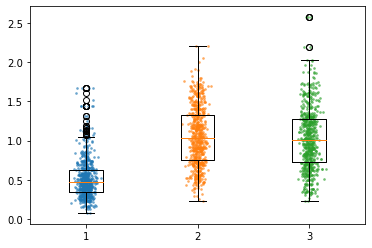

In [189]:
#For area

g1 = measurement_for_all_fov_df['normalized_fib_pos_Pol2S5']
g2 = measurement_for_all_fov_df['normalized_fib_neg_Pol2S5']
g3 = measurement_for_all_fov_df['normalized_random_Pol2S5']



#sp_low = min(len(g1),len(g2),len(g3))
sp_low = min(len(g1),len(g2), len(g3))

g1 = np.random.choice(g1, sp_low)
g2 = np.random.choice(g2, sp_low)
g3 = np.random.choice(g3, sp_low)

boxplot_pol2= plt.boxplot([g1,g2,g3], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2,g3]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 3, alpha=0.5)


from scipy.stats import kruskal
p4 = kruskal(g1,g2,g3)

#U1, p1 = mannwhitneyu(g1,g2)

#print(f"MW comparision: {p1}")



print(f"three samples comparision: {p4}")





factor_name = 'Pol2S5'


col_name1 = f'fibri_positive_{factor_name}'
col_name2 = f'fibri_negative_subset_{factor_name}'
col_name3 = f'radomized_subset_chr_{factor_name}'


df = pd.DataFrame(columns = [col_name1, col_name2, col_name3])

df[col_name1] = g1
df[col_name2] = g2
df[col_name3] = g3

df.to_excel (data_main_folder
                     + os.sep + 
             f'Updated_measurement_to_use_for_{factor_name}_figure.xlsx', index=False)

three samples comparision: KruskalResult(statistic=1297.0944292111446, pvalue=2.1853622816197216e-282)


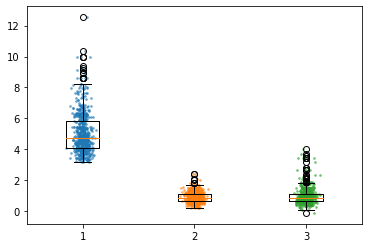

In [190]:
g1 = measurement_for_all_fov_df['normalized_fib_pos_fibrill']
g2 = measurement_for_all_fov_df['normalized_fib_neg_fibrill']
g3 = measurement_for_all_fov_df['normalized_random_fibrill']



#sp_low = min(len(g1),len(g2),len(g3))
sp_low = min(len(g1),len(g2), len(g3))

g1 = np.random.choice(g1, sp_low)
g2 = np.random.choice(g2, sp_low)
g3 = np.random.choice(g3, sp_low)

boxplot_pol2= plt.boxplot([g1,g2,g3], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2,g3]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 3, alpha=0.5)


from scipy.stats import kruskal
p4 = kruskal(g1,g2,g3)

#U1, p1 = mannwhitneyu(g1,g2)

#print(f"MW comparision: {p1}")



print(f"three samples comparision: {p4}")





factor_name = 'Fibrill'


col_name1 = f'fibri_positive_{factor_name}'
col_name2 = f'fibri_negative_subset_{factor_name}'
col_name3 = f'radomized_subset_chr_{factor_name}'


df = pd.DataFrame(columns = [col_name1, col_name2, col_name3])

df[col_name1] = g1
df[col_name2] = g2
df[col_name3] = g3

df.to_excel (data_main_folder
                     + os.sep + 
             f'Updated_measurement_to_use_for_{factor_name}_figure.xlsx', index=False)